In [1]:
import pandas as pd

# Load the spreadsheet (replace 'your_file.xlsx' with the actual filename)
df = pd.read_csv('/Users/apple/Downloads/2025-02-14_prod_p1_cb_sp25.csv')

# Function to manually parse the 'response_@' column
def parse_response(response):
    if not isinstance(response, str):  # Handle NaN or non-string values
        return []
    
    response = response.strip('{}')  # Remove curly braces
    attributes = [attr.split(':', 1) for attr in response.split(',') if ':' in attr]  # Split key-value pairs
    attributes = [(k.strip('" '), v.strip('" ')) for k, v in attributes]  # Clean up whitespace and quotes
    return attributes

# Apply parsing and explode into multiple rows
df_expanded = df.assign(response2=df['response2'].apply(parse_response)).explode('response2')

# Remove empty rows caused by NaN values
df_expanded = df_expanded[df_expanded['response2'].notna()]

# Convert tuples into separate columns
df_expanded[['attribute_type', 'attribute_value']] = pd.DataFrame(df_expanded['response2'].tolist(), index=df_expanded.index)

# Drop the original 'response_@' column since it's now split
df_expanded.drop(columns=['response2'], inplace=True)

df_cleaned = df_expanded[['exp_condition', 'attribute_value']]

# Save to a new spreadsheet
print(df_cleaned)

df_cleaned.to_csv('/Users/apple/Downloads/cleaned_dataset_2.csv', index=False)

#print("Dataset cleaned and saved as 'cleaned_dataset.xlsx'")


     exp_condition attribute_value
6          shampoo            asdf
6          shampoo            asdf
6          shampoo            asdf
6          shampoo             asf
14           sedan           Speed
...            ...             ...
2440         razor         remover
2446       shampoo         natural
2446       shampoo         shampoo
2446       shampoo        cleaning
2446       shampoo     lotion like

[3244 rows x 2 columns]


In [2]:
# Assign row indices (ensuring unique attribute values align correctly)
df_cleaned['row_index'] = df_cleaned.groupby('exp_condition').cumcount()

# Pivoting: `exp_condition` → Columns, `attribute_value` → Rows
df_pivoted = df_cleaned.pivot(index="row_index", columns="exp_condition", values="attribute_value")

# Reset index for cleaner output
df_pivoted = df_pivoted.reset_index(drop=True)

print(df_pivoted)

df_pivoted.to_csv('/Users/apple/Downloads/pivoted_dataset.csv', index=False)

exp_condition      lipstick            razor     sedan      shampoo
0                   Magenta            green     Speed         asdf
1                      Wood      overlapping  Capacity         asdf
2              Unattractive            black    Safety         asdf
3                      ILIA  neatly arranged    Height          asf
4                 Red color           orange    Smooth        cheap
...                     ...              ...       ...          ...
999                     NaN              NaN       NaN      shampoo
1000                    NaN              NaN       NaN      natural
1001                    NaN              NaN       NaN      shampoo
1002                    NaN              NaN       NaN     cleaning
1003                    NaN              NaN       NaN  lotion like

[1004 rows x 4 columns]


/var/folders/fh/zpfnszp52630r0g2r88wrnmw0000gn/T/ipykernel_84150/3856733966.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['row_index'] = df_cleaned.groupby('exp_condition').cumcount()


In [3]:
print(df_pivoted)
df_pivoted_weighted = df_pivoted

df_pivoted_weighted = df_pivoted_weighted.drop_duplicates(subset=["lipstick","razor", "sedan", "shampoo"])
print(df_pivoted_weighted)
df_pivoted_weighted.to_csv('/Users/apple/Downloads/pivoted_weighted_dataset_1.csv', index=False)

exp_condition      lipstick            razor     sedan      shampoo
0                   Magenta            green     Speed         asdf
1                      Wood      overlapping  Capacity         asdf
2              Unattractive            black    Safety         asdf
3                      ILIA  neatly arranged    Height          asf
4                 Red color           orange    Smooth        cheap
...                     ...              ...       ...          ...
999                     NaN              NaN       NaN      shampoo
1000                    NaN              NaN       NaN      natural
1001                    NaN              NaN       NaN      shampoo
1002                    NaN              NaN       NaN     cleaning
1003                    NaN              NaN       NaN  lotion like

[1004 rows x 4 columns]
exp_condition      lipstick            razor     sedan      shampoo
0                   Magenta            green     Speed         asdf
1                      

In [5]:
pivoted_weighted = df_pivoted_weighted
from sentence_transformers import SentenceTransformer


# Load the model
model = SentenceTransformer("BAAI/bge-base-en-v1.5")


def embed_column(df, column_name):
    # Handle NaN and convert everything to string
    df[column_name] = df[column_name].fillna("").astype(str)
    
    # Get the embeddings for the current column
    embeddings = model.encode(df[column_name].tolist(), convert_to_tensor=False)  # Convert to NumPy array
    
    # Convert embeddings into separate columns (one for each dimension)
    embedding_dim = len(embeddings[0])  # Number of dimensions
    embedding_columns = [f"{column_name}_dim_{i}" for i in range(embedding_dim)]
    
    # Create a DataFrame for the embeddings
    df_embeddings = pd.DataFrame(embeddings, columns=embedding_columns)
    
    return df_embeddings

# Embed each of the three columns separately and save them into separate DataFrames
lipstick_embeddings = embed_column(pivoted_weighted, "lipstick")
razor_embeddings = embed_column(pivoted_weighted, "razor")
sedan_embeddings = embed_column(pivoted_weighted, "sedan")
shampoo_embeddings = embed_column(pivoted_weighted, "shampoo")

# Now you have 3 DataFrames:
# 1. lipstick_embeddings
# 2. sedan_embeddings
# 3. shampoo_embeddings

# Print the results to verify
print("Lipstick Embeddings DataFrame:")
print(lipstick_embeddings.head())

print("\nSedan Embeddings DataFrame:")
print(sedan_embeddings.head())

print("\nShampoo Embeddings DataFrame:")
print(shampoo_embeddings.head())

/opt/anaconda3/envs/mapss-thesis_1python=3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/var/folders/fh/zpfnszp52630r0g2r88wrnmw0000gn/T/ipykernel_84150/3020994173.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = df[column_name].fillna("").astype(str)
/var/folders/fh/zpfnszp52630r0g2r88wrnmw0000gn/T/ipykernel_84150/3020994173.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydat

Lipstick Embeddings DataFrame:
   lipstick_dim_0  lipstick_dim_1  lipstick_dim_2  lipstick_dim_3  \
0       -0.007351       -0.016884        0.031296        0.066219   
1        0.022339        0.034948       -0.008309        0.040229   
2       -0.003993        0.004041        0.011087       -0.016025   
3       -0.048517       -0.029848       -0.003838        0.011074   
4       -0.019303        0.017344        0.001881        0.028610   

   lipstick_dim_4  lipstick_dim_5  lipstick_dim_6  lipstick_dim_7  \
0        0.047084        0.013191       -0.017314        0.032043   
1        0.005766        0.040911        0.036407        0.010883   
2        0.021709        0.047771        0.018213        0.057182   
3       -0.011172        0.067003        0.017618        0.010752   
4       -0.007796        0.081743       -0.006841       -0.003155   

   lipstick_dim_8  lipstick_dim_9  ...  lipstick_dim_758  lipstick_dim_759  \
0       -0.025363       -0.050205  ...         -0.018802     

16


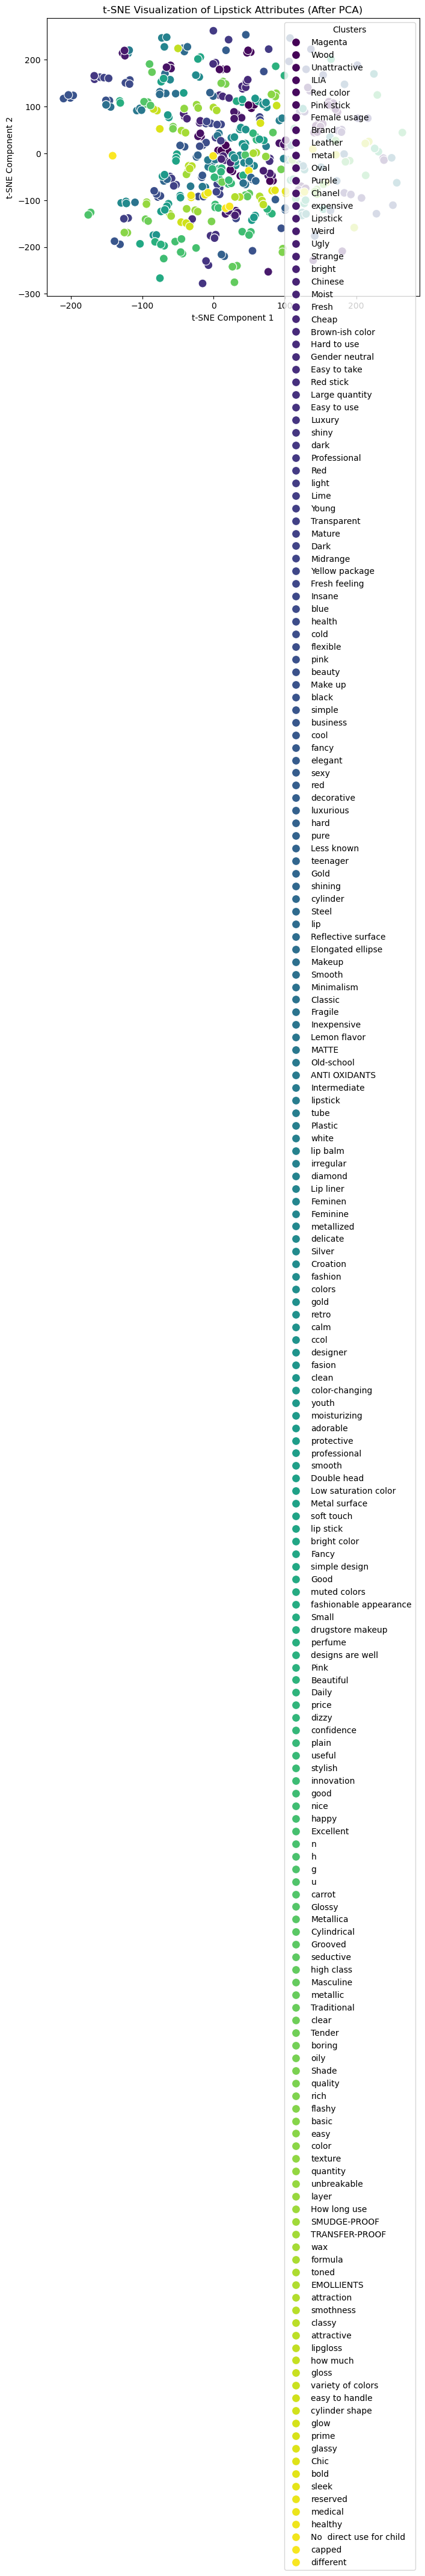

In [8]:
import pandas as pd
import numpy as np

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

import seaborn as sns



# Step 1: PCA (Reduce 1024D → 50D)
pca = PCA(n_components=50, random_state=42)
lipstick_pca = pca.fit_transform(lipstick_embeddings)  

# Step 2: t-SNE (Reduce 50D → 2D)
tsne = TSNE(n_components=2, perplexity=5, random_state=42)
lipstick_tsne = tsne.fit_transform(lipstick_pca)

# Convert t-SNE results to DataFrame
lipstick_tsne_df = pd.DataFrame(lipstick_tsne, columns=["tSNE_1", "tSNE_2"])
lipstick_tsne_df["attribute"] = pivoted_weighted["lipstick"]  # Add original attribute names

print(lipstick_tsne_df["attribute"].isna().sum())  # Count NaNs in "attribute"
lipstick_tsne_df = lipstick_tsne_df.dropna(subset=["attribute"])
# Step 3: KNN Clustering
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(lipstick_tsne_df[["tSNE_1", "tSNE_2"]], lipstick_tsne_df["attribute"])
lipstick_tsne_df["cluster"] = knn.predict(lipstick_tsne_df[["tSNE_1", "tSNE_2"]])

# Step 4: Visualization
plt.figure(figsize=(8, 6))
sns.scatterplot(data=lipstick_tsne_df, x="tSNE_1", y="tSNE_2", hue="cluster", palette="viridis", s=100)
plt.title("t-SNE Visualization of Lipstick Attributes (After PCA)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Clusters")
plt.show()

In [9]:
# Group by 'cluster' and get the top 10 most frequent attributes for each cluster
top_attributes_per_cluster = (
    lipstick_tsne_df.groupby("cluster")["attribute"]
    .value_counts()
    .groupby(level=0)
    .head(10)
    .reset_index()
)

# Display the result in a readable format
for cluster in top_attributes_per_cluster["cluster"].unique():
    print(f"\n🔹 Cluster {cluster}:")
    cluster_attributes = top_attributes_per_cluster[top_attributes_per_cluster["cluster"] == cluster]["attribute"]
    print(", ".join(map(str, cluster_attributes.tolist())))  # Convert to a list and join for easy copying



🔹 Cluster :


🔹 Cluster ANTI OXIDANTS:
ANTI OXIDANTS, Natural, extravegent, natural

🔹 Cluster Beautiful:
Beautiful, handsome, pretty

🔹 Cluster Brand:
Brand, Famous brand, YSL brand

🔹 Cluster Brown-ish color:
Brown-ish color, Pink color, Pink-ish color

🔹 Cluster Chanel:
Chanel, Gucci, posh

🔹 Cluster Cheap:
Cheap, cheap

🔹 Cluster Chic:
Chic, chic

🔹 Cluster Chinese:
Chinese, chrome, name, polish

🔹 Cluster Classic:
Classic, classic

🔹 Cluster Croation:
Croation, carrot, charcoal

🔹 Cluster Cylindrical:
Cylindrical

🔹 Cluster Daily:
Daily, average, daily, unleash

🔹 Cluster Dark:
Dark, Dark color, dark blue

🔹 Cluster Double head:
Double head, how was effect

🔹 Cluster EMOLLIENTS:
EMOLLIENTS

🔹 Cluster Easy to take:
Easy to take, convenient

🔹 Cluster Easy to use:
Easy to use

🔹 Cluster Elongated ellipse:
Elongated ellipse, Octagonal

🔹 Cluster Excellent:
Excellent, excellent, good

🔹 Cluster Fancy:
Fancy appearance

🔹 Cluster Female usage:
Female usage, For women, women

🔹 Cluster

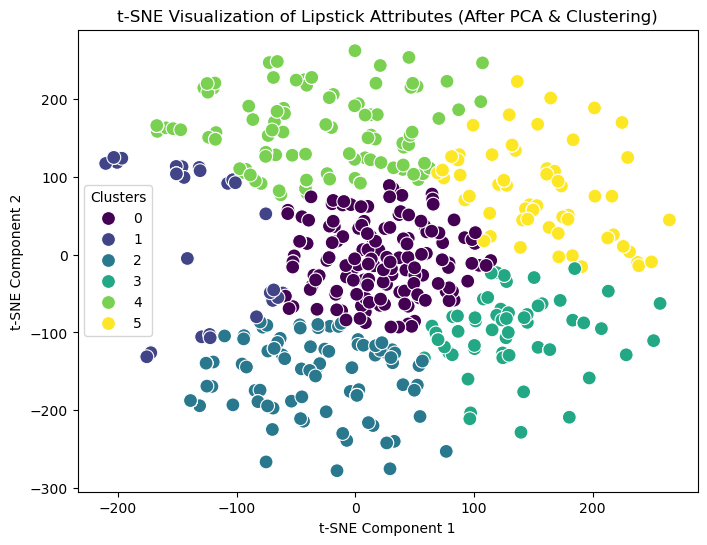

In [10]:
from sklearn.cluster import KMeans

# Step 3: KMeans Clustering (6 clusters)
kmeans = KMeans(n_clusters=6, random_state=42, n_init=10)
lipstick_tsne_df["cluster"] = kmeans.fit_predict(lipstick_tsne_df[["tSNE_1", "tSNE_2"]])

# Step 4: Visualization
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.scatterplot(data=lipstick_tsne_df, x="tSNE_1", y="tSNE_2", hue="cluster", palette="viridis", s=100)
plt.title("t-SNE Visualization of Lipstick Attributes (After PCA & Clustering)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Clusters")
plt.show()

In [11]:
# Get top 10 attributes per cluster
top_attributes_per_cluster = {}

for cluster in range(6):  # Loop through each of the 6 clusters
    cluster_data = lipstick_tsne_df[lipstick_tsne_df["cluster"] == cluster]  # Filter cluster
    top_attributes = cluster_data["attribute"].value_counts().head(10).index.tolist()  # Get top 10 attributes
    top_attributes_per_cluster[cluster] = top_attributes

# Print results
for cluster, attributes in top_attributes_per_cluster.items():
    print(f"Cluster {cluster}: {attributes}")


Cluster 0: ['cool', 'Ugly', 'boring', 'useful', 'fasion', 'tube', 'prime', 'soft touch', 'wax', 'pure']
Cluster 1: ['', 'g', 'black', 'glassy', 'delicate', 'Black', 'youth', 'Makeup', 'drugstore makeup', 'black and gold']
Cluster 2: ['simple', 'nice', 'Easy to use', 'good', 'expensive', 'luxury', 'Luxury', 'beauty', 'happy', 'Transparent']
Cluster 3: ['classy', 'beauty', 'shiny', 'rich', 'elegant', 'u', 'expensive', 'fashion', 'plastic', 'Classic']
Cluster 4: ['red', 'pink', 'Red', 'lip balm', 'dark', 'metal', 'texture', 'Pink', 'blue', 'lipstick']
Cluster 5: ['light', 'pink', 'h', 'n', 'Brand', 'Pink', 'Female usage', 'bright', 'gold', 'reserved']


16


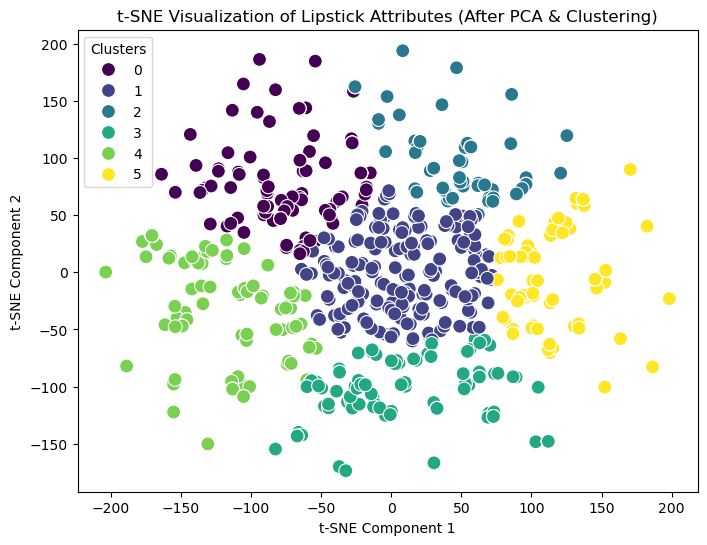

In [17]:
# Step 1: PCA (Reduce 1024D → 50D)
pca = PCA(n_components=50, random_state=42)
razor_pca = pca.fit_transform(razor_embeddings)  

# Step 2: t-SNE (Reduce 50D → 2D)
tsne = TSNE(n_components=2, perplexity=5, random_state=42)
razor_tsne = tsne.fit_transform(razor_pca)

# Convert t-SNE results to DataFrame
razor_tsne_df = pd.DataFrame(razor_tsne, columns=["tSNE_1", "tSNE_2"])
razor_tsne_df["attribute"] = pivoted_weighted["razor"]  # Add original attribute names

print(razor_tsne_df["attribute"].isna().sum())  # Count NaNs in "attribute"
razor_tsne_df = razor_tsne_df.dropna(subset=["attribute"])
# Step 3: KNN Clustering
# Step 3: KMeans Clustering (6 clusters)
kmeans = KMeans(n_clusters=6, random_state=42, n_init=10)
razor_tsne_df["cluster"] = kmeans.fit_predict(razor_tsne_df[["tSNE_1", "tSNE_2"]])

# Step 4: Visualization
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.scatterplot(data=razor_tsne_df, x="tSNE_1", y="tSNE_2", hue="cluster", palette="viridis", s=100)
plt.title("t-SNE Visualization of Razor Attributes (After PCA & Clustering)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Clusters")
plt.show()

In [19]:
# Get top 10 attributes per cluster
top_attributes_per_cluster = {}

for cluster in range(6):  # Loop through each of the 6 clusters
    cluster_data = razor_tsne_df[razor_tsne_df["cluster"] == cluster]  # Filter cluster
    top_attributes = cluster_data["attribute"].value_counts().head(10).index.tolist()  # Get top 10 attributes
    top_attributes_per_cluster[cluster] = top_attributes

# Print results
for cluster, attributes in top_attributes_per_cluster.items():
    print(f"Cluster {cluster}: {attributes}")


Cluster 0: ['sharp', 'blade', 'G', 'shaving', 'silver', 'metal', 'Five blades', 'Pivoting head', 'smooth', 'smoothening']
Cluster 1: ['useful', 'none', 'TRUST', 'B', 'D', 'S', 'cool', 'cleaning', 'rectangle', 'I']
Cluster 2: ['G', 'K', 'J', 'Y', 'masculine', 'manly', 'white', 'R', 'colorful', 'black']
Cluster 3: ['', 'QUALITY', 'plastic', 'cleaner', 'simple', 'disposable', 'Disposable', 'convenient', 'handle', 'portable']
Cluster 4: ['shaver', 'remover', 'cut', 'razor', 'grooming', 'TRIMMER', 'safe', 'rugged', 'strong', 'shaving']
Cluster 5: ['H', 'F', 'U', 'T', 'feminine', 'L', 'expensive', 'fancy', 'sleek', 'elegant']


16


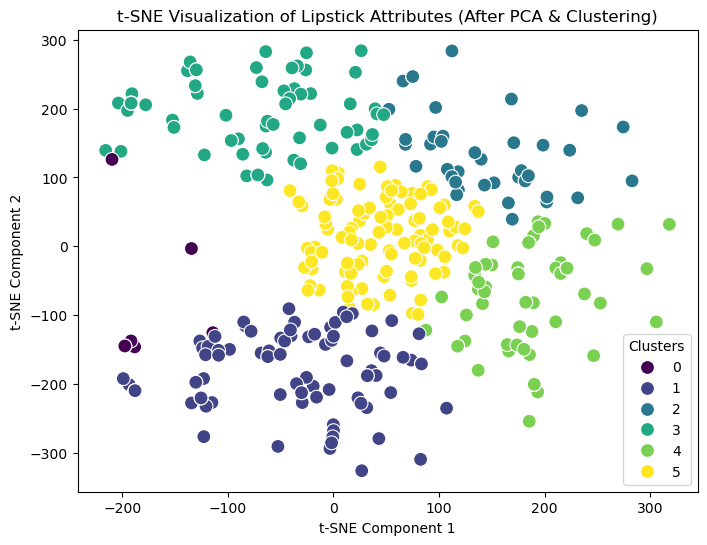

In [20]:
# Step 1: PCA (Reduce 1024D → 50D)
pca = PCA(n_components=50, random_state=42)
sedan_pca = pca.fit_transform(sedan_embeddings)  

# Step 2: t-SNE (Reduce 50D → 2D)
tsne = TSNE(n_components=2, perplexity=5, random_state=42)
sedan_tsne = tsne.fit_transform(sedan_pca)

# Convert t-SNE results to DataFrame
sedan_tsne_df = pd.DataFrame(sedan_tsne, columns=["tSNE_1", "tSNE_2"])
sedan_tsne_df["attribute"] = pivoted_weighted["sedan"]  # Add original attribute names

print(sedan_tsne_df["attribute"].isna().sum())  # Count NaNs in "attribute"
sedan_tsne_df = sedan_tsne_df.dropna(subset=["attribute"])
# Step 3: KNN Clustering
# Step 3: KMeans Clustering (6 clusters)
kmeans = KMeans(n_clusters=6, random_state=42, n_init=10)
sedan_tsne_df["cluster"] = kmeans.fit_predict(sedan_tsne_df[["tSNE_1", "tSNE_2"]])

# Step 4: Visualization
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.scatterplot(data=sedan_tsne_df, x="tSNE_1", y="tSNE_2", hue="cluster", palette="viridis", s=100)
plt.title("t-SNE Visualization of Lipstick Attributes (After PCA & Clustering)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Clusters")
plt.show()

In [21]:
# Get top 10 attributes per cluster
top_attributes_per_cluster = {}

for cluster in range(6):  # Loop through each of the 6 clusters
    cluster_data = sedan_tsne_df[sedan_tsne_df["cluster"] == cluster]  # Filter cluster
    top_attributes = cluster_data["attribute"].value_counts().head(10).index.tolist()  # Get top 10 attributes
    top_attributes_per_cluster[cluster] = top_attributes

# Print results
for cluster, attributes in top_attributes_per_cluster.items():
    print(f"Cluster {cluster}: {attributes}")


Cluster 0: ['', 'e', 'stubby', 'modern']
Cluster 1: ['white', 'cool', 'tinted', 'White color', 'glasses', 'White', 'silver', 'it is white', 'light', 'lights']
Cluster 2: ['sedan', 'four door', 'sporty', 'compact', 'Security', 'short', '4-door', 'size', 'door', 'make']
Cluster 3: ['fast', 'modern', 'design', 'expensive', 'car', 'Fast', 'Convenient', 'nice', 'Design', 'happy']
Cluster 4: ['clean', 'sleek', 'color', 'wheels', 'Comfortable', 'model', 'long', 'grey', 'comfortable', 'Normal']
Cluster 5: ['good', 'n', 'aerodynamic', 'Price', 'cheap', 'Capacity', 'f', 'sharp', 'd', 'crossover']


16


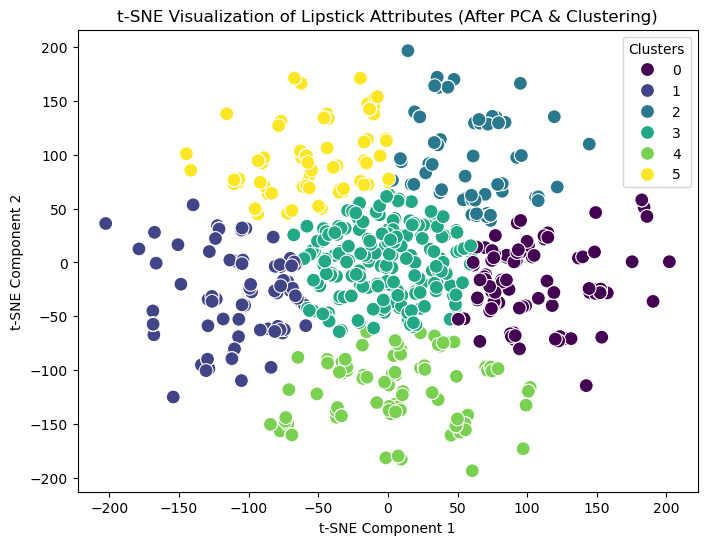

In [22]:
# Step 1: PCA (Reduce 1024D → 50D)
pca = PCA(n_components=50, random_state=42)
shampoo_pca = pca.fit_transform(shampoo_embeddings)  

# Step 2: t-SNE (Reduce 50D → 2D)
tsne = TSNE(n_components=2, perplexity=5, random_state=42)
shampoo_tsne = tsne.fit_transform(shampoo_pca)

# Convert t-SNE results to DataFrame
shampoo_tsne_df = pd.DataFrame(shampoo_tsne, columns=["tSNE_1", "tSNE_2"])
shampoo_tsne_df["attribute"] = pivoted_weighted["shampoo"]  # Add original attribute names

print(shampoo_tsne_df["attribute"].isna().sum())  # Count NaNs in "attribute"
shampoo_tsne_df = shampoo_tsne_df.dropna(subset=["attribute"])
# Step 3: KNN Clustering
# Step 3: KMeans Clustering (6 clusters)
kmeans = KMeans(n_clusters=6, random_state=42, n_init=10)
shampoo_tsne_df["cluster"] = kmeans.fit_predict(shampoo_tsne_df[["tSNE_1", "tSNE_2"]])

# Step 4: Visualization
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.scatterplot(data=shampoo_tsne_df, x="tSNE_1", y="tSNE_2", hue="cluster", palette="viridis", s=100)
plt.title("t-SNE Visualization of Lipstick Attributes (After PCA & Clustering)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Clusters")
plt.show()

In [23]:
# Get top 10 attributes per cluster
top_attributes_per_cluster = {}

for cluster in range(6):  # Loop through each of the 6 clusters
    cluster_data = shampoo_tsne_df[shampoo_tsne_df["cluster"] == cluster]  # Filter cluster
    top_attributes = cluster_data["attribute"].value_counts().head(10).index.tolist()  # Get top 10 attributes
    top_attributes_per_cluster[cluster] = top_attributes

# Print results
for cluster, attributes in top_attributes_per_cluster.items():
    print(f"Cluster {cluster}: {attributes}")

Cluster 0: ['Small', 'Hard', 'cheap', 'R', 'brown', 'Bubble', 'Black', 'Brown', 'Ugly color', 'black']
Cluster 1: ['shampoo', 'clean', 'Liquid', 'Scents', 'Scent', 'REMOVER', 'feminine', 'LOTION', 'Hair Care', 'smooth']
Cluster 2: ['simple', 'Volume', 'Cylindrical', 'Cap', 'WRWR', 'H', 'round', 'QEQE', 'QEQEQE', 'font']
Cluster 3: ['Friendly', 'thick', 'youth', 'smooth', 'Vegan', 'angular', 'old', 'Y', 'girly', 'J']
Cluster 4: ['White', 'pink', 'Brand', 'white', 'Blue', 'color', 'blue', 'natural', 'Color', 'Pink']
Cluster 5: ['WTWT', 'useful', 'expensive', 'Hydrating', 'CLEANER', 'WTWTWT', 'plastic', 'fresh', 'Refreshing', 'T']
